In [5]:
# the ROOT framework 
import ROOT as rt
# load the larcv library
from larcv import larcv
import numpy as np
# load matplotlib for image viewing
import matplotlib.pyplot as plt

In [2]:
# import pytorch and uresnet network
import torch
import uresnet
from uresnet.models.uresnet_dense import UResNet
from uresnet.models.uresnet_dense import SegmentationLoss
from uresnet.flags import URESNET_FLAGS

In [3]:
# Configure network and load it
flags = URESNET_FLAGS()
flags.DATA_DIM = 2
flags.URESNET_FILTERS = 16
flags.URESNET_NUM_STRIDES = 4
flags.SPATIAL_SIZE = 256
flags.NUM_CLASS = 3 # bg, shower, track                                                                                                                                                                     
flags.LEARNING_RATE = 1.0e-3
flags.WEIGHT_DECAY = 1.0e-4
flags.BATCH_SIZE = 16
flags.checkpoint_file = "../checkpoint.run1.11000th.tar" # 16 features, images not conditioned

DEVICE = torch.device("cpu")

# MODEL
model = UResNet(flags).to(DEVICE)

device_map = {"cuda:0":"cpu",
              "cuda:1":"cpu"}
checkpoint = torch.load( flags.checkpoint_file, map_location=device_map )
model.load_state_dict( checkpoint["state"] )
model.eval()
# print model

UResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
    (2): ReLU()
  )
  (double_resnet): ModuleList(
    (0): DoubleResnet(
      (resnet1): ResNetModule(
        (shortcut): Sequential(
          (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
        (residual1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
        (residual2): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
      )
      (resnet2): ResNetModule(
        (shortcut): Sequential(
          (0): Conv2d(32, 32, ker

In [21]:
# LOAD SAMPLES
"""samples.npy  testset_codes.npy  testset_imgs.npy  testset_recons.npy"""
samples  = np.load("../vqvae_samples/samples.npy")
testimg  = np.load("../vqvae_samples/testset_imgs.npy")
testreco = np.load("../vqvae_samples/testset_recons.npy")
testcode = np.load("../vqvae_samples/testset_codes.npy")
print samples.shape
print testimg.shape
print testreco.shape
print testcode.shape

# switch to pytorch form
samples = samples.reshape( (30,1,64,64) )
print samples.shape

# condition
samples *= 70.0
samples[ samples<10 ] = 0
samples[ samples>1000 ] = 1000

print samples[samples>10].mean()

(30, 64, 64, 1)
(30, 64, 64, 1)
(30, 64, 64, 1)
(30, 16, 16)
(30, 1, 64, 64)
134.5933


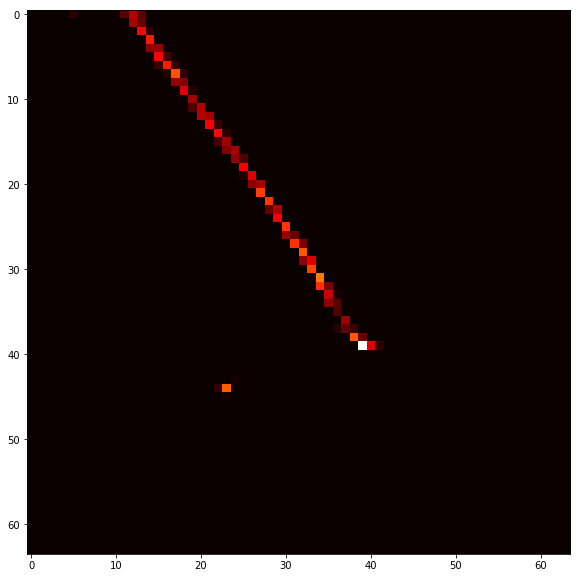

In [22]:
# PLOT EXAMPLE
fig, ax = plt.subplots(1,1,figsize=(10, 10))

# LEFT: PREDICTION
ax.imshow(samples[10,0,:,:], cmap='hot', interpolation='nearest')
fig.show()

In [23]:
# run network
image_t = torch.from_numpy( samples ).to(DEVICE)
with torch.no_grad():
    out_t = model.forward( image_t )
print out_t.shape
# use softmax
pred_t = torch.argmax( torch.nn.Softmax(dim=1)(out_t), dim=1, keepdim=True ).numpy()
print "pred-shape: ",pred_t.shape
# keep scores on interesting pixels
pred_t[ samples<10 ] = 0


torch.Size([30, 3, 64, 64])
pred-shape:  (30, 1, 64, 64)


[24  0 17  6  4 22  1 27  8]


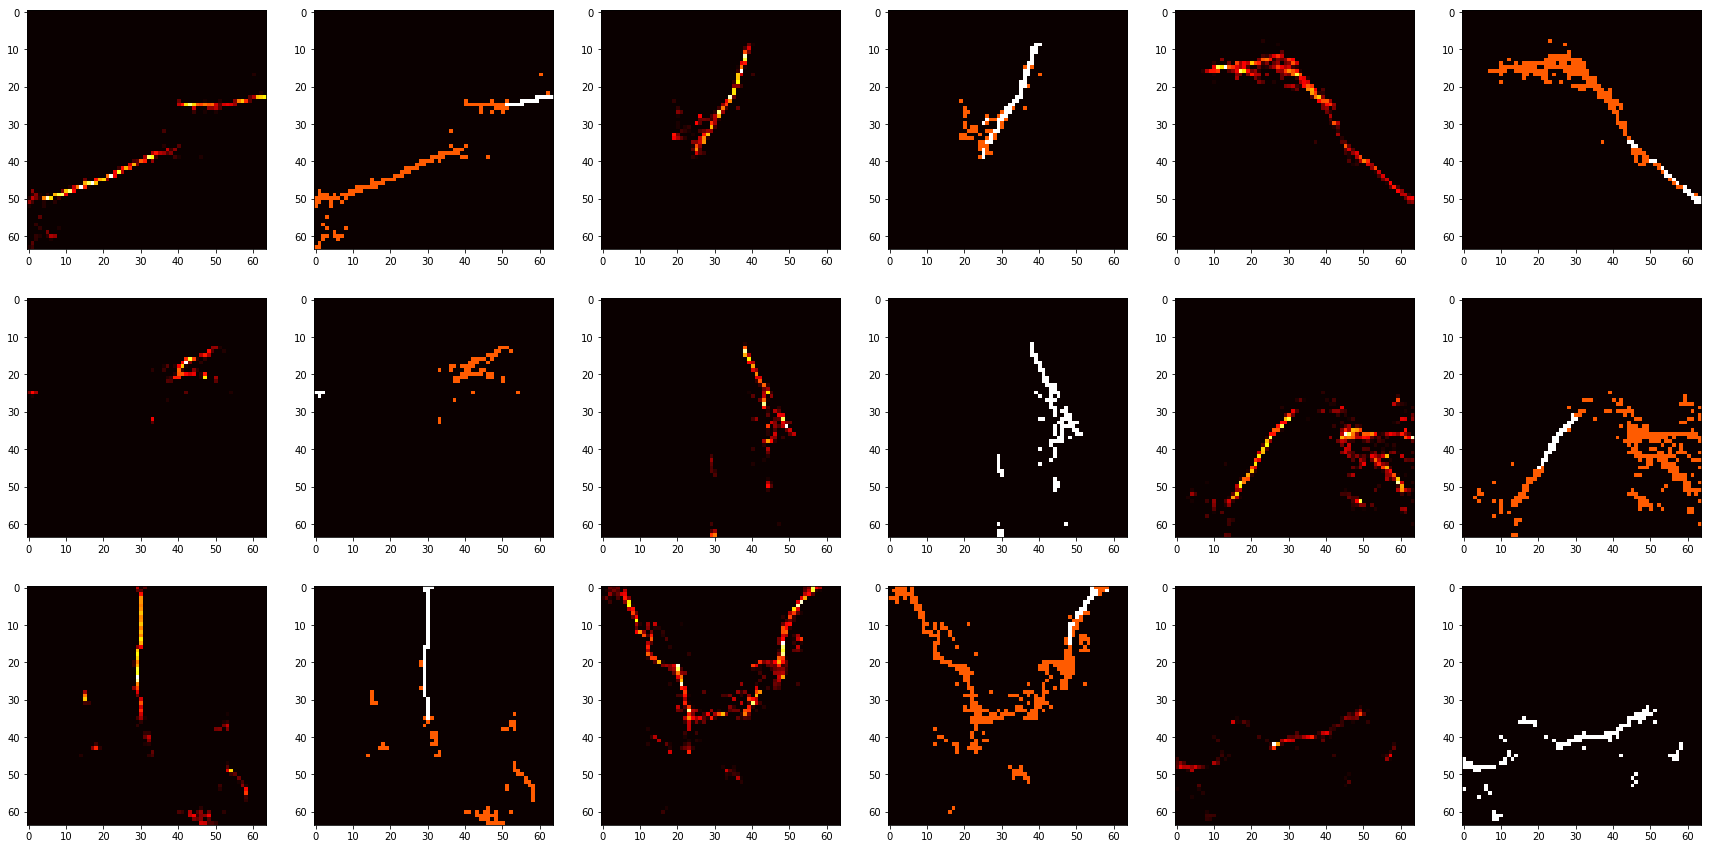

In [42]:
index = np.arange(samples.shape[0])
np.random.shuffle( index )

fig, ax = plt.subplots(3,6,figsize=(30, 15))
print index[:9]
for n,idx in enumerate(index[:9]): 
    # LEFT: INPUT
    ax[n/3,2*(n%3)].imshow(samples[idx,0,:,:], cmap='hot', interpolation='nearest')
    ax[n/3,2*(n%3)+1].imshow(pred_t[idx,0,:,:], cmap='hot', interpolation='nearest')

fig.show()

[ 4 25 24 13  1 20  8 18 26]


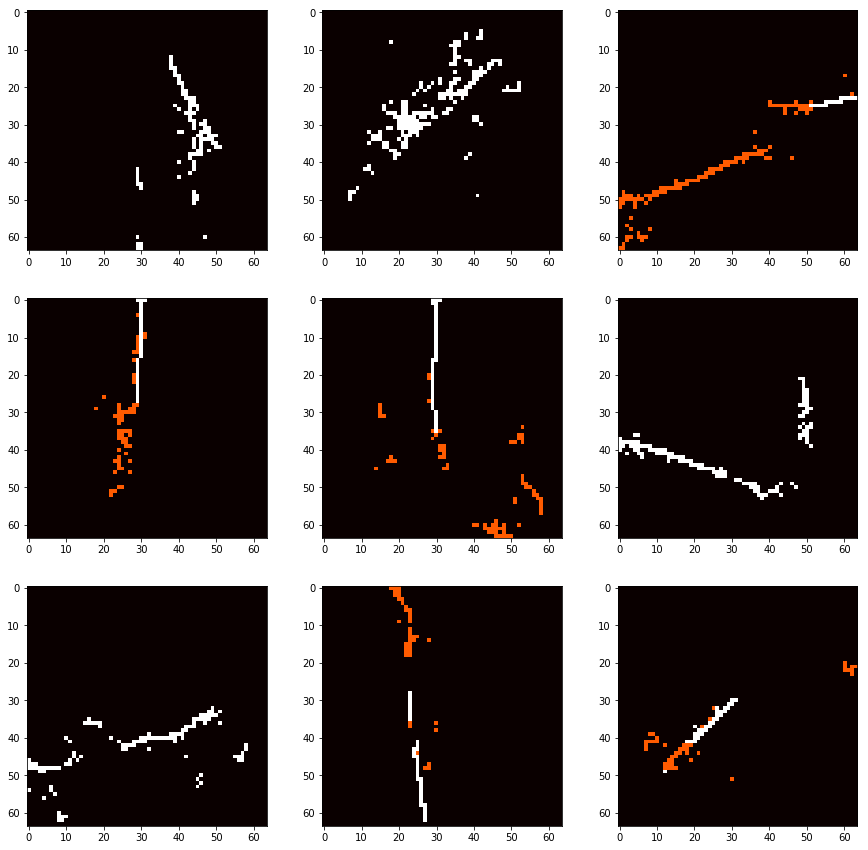

In [38]:
fig, ax = plt.subplots(3,3,figsize=(15, 15))
print index[:9]
for n,idx in enumerate(index[:9]): 
    # LEFT: INPUT
    ax[n/3,n%3].imshow(pred_t[idx,0,:,:], cmap='hot', interpolation='nearest')

fig.show()